# Benchmarking RNA-seq DEG Methods with the Dexamethasone Benchmark

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs two DEG methods, characteristic direction and log fold change, on the data using code adapted from Bulk RNA-seq Analysis pipeline appyter: https://appyters.maayanlab.cloud/Bulk_RNA_seq/

The results of the DEG methods are benchmarked after enrichment analysis focused on the NR3C1 transcription factor, the known target of dexamethasone.

In [1]:
# Import libraries
import statistics
import math
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
from sklearn import preprocessing
import warnings
import requests
import json
import time
import scipy.stats as ss
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction

# Load in Data

Using data from GEO from the study, "The effect of lithium and dexamethasone on fetal rat metatarsal bones transcriptome" 
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE186104 

In [2]:
# Set all variables
meta_class_column_name = 'Sample_characteristics_ch1'
control_name = 'treatment: standard cultivation medium'
treatment = 'treatment: standard cultivation medium + dexamethason'
meta_data_filename = 'GSE186104_series_matrix.txt'
rnaseq_data_filename = 'GSE186104_cross_tabulation_of_gene_expression.txt'
low_expression_threshold = 0.3

In [3]:
# Load in data
try:
    meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0, dtype=str)
except:
    print("Error! Please load a metadata file in txt or tsv format")
try:
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
except:
    print("Error! Please load a RNA-seq expression file in txt or tsv format")
meta_df.index = meta_df.index.map(str)

# Match samples between the metadata and the datasets
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' is not in metadata")
    
meta_df = meta_df[meta_df.index.isin(expr_df.columns)]

# sort metadata by class labels; control first
classes = list(meta_df[meta_class_column_name].unique())
classes.remove(control_name)
classes.insert(0, control_name)
meta_df['tmp_class'] = pd.Categorical(meta_df[meta_class_column_name], classes)
meta_df = meta_df.sort_values('tmp_class')
meta_df = meta_df.drop('tmp_class', axis=1)
expr_df = expr_df.loc[:,meta_df.index]
expr_df = expr_df.groupby(expr_df.index).sum()
try:
    assert(meta_df.shape[0]==expr_df.shape[1])
except:
    print("Error! Input files are in a wrong format.")

dataset = dict()
current_dataset = 'rawdata'
dataset[current_dataset] = expr_df
dataset['dataset_metadata'] = meta_df

In [4]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
current_dataset += '+filter_genes'
dataset[current_dataset] = expr_df

In [5]:
# Display meta data
meta_df

,Sample_title,Sample_characteristics_ch1
Sample_geo_accession,,
GSM5632354,C1: Untreated control replicate 1,treatment: standard cultivation medium
GSM5632355,C2: Untreated control replicate 2,treatment: standard cultivation medium
GSM5632356,C3: Untreated control replicate 3,treatment: standard cultivation medium
GSM5632357,Dex1: Dexamethason treated sample replicate 1,treatment: standard cultivation medium + dexam...
GSM5632358,Dex2: Dexamethason treated sample replicate 2,treatment: standard cultivation medium + dexam...
GSM5632359,Dex3: Dexamethason treated sample replicate 3,treatment: standard cultivation medium + dexam...
GSM5632360,Li1: Lithium treated sample replicate 1,treatment: standard cultivation medium + lithium
GSM5632361,Li2: Lithium treated sample replicate 2,treatment: standard cultivation medium + lithium
GSM5632362,Li3: Lithium treated sample replicate 3,treatment: standard cultivation medium + lithium


In [6]:
# Display expression data
expr_df

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359,GSM5632360,GSM5632361,GSM5632362,GSM5632363,GSM5632364,GSM5632365
gene,,,,,,,,,,,,
A1i3,160,60,196,328,274,287,179,188,343,113,93,119
A2m,32,15,19,62,65,36,28,34,68,23,29,29
A2ml1,1,0,0,0,2,0,3,0,0,2,4,1
A3galt2,80,36,75,68,70,47,63,44,104,55,69,76
A4galt,0,0,2,0,1,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
l7Rn6,392,199,385,174,185,142,189,245,303,269,361,407
mrpl11,374,218,233,144,192,133,156,176,244,210,327,287
mrpl24,611,344,560,222,316,222,286,327,497,369,513,569


# Data Normalization

In [7]:
# Define functions for normalization
def logCPM(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = (data/data.sum())*10**6
        data = data.fillna(0)
        data = np.log2(data+1)

    # Return
    return data

def normalize(dataset, current_dataset, logCPM_normalization, z_normalization):
    normalization = current_dataset
    if logCPM_normalization == True:  
        data = dataset[normalization]
        normalization += '+logCPM'
        dataset[normalization] = logCPM(data)
        
    if z_normalization == True:
        data = dataset[normalization]
        normalization += '+z_norm'    
        dataset[normalization] = data.T.apply(ss.zscore, axis=0).T.dropna()

    return dataset, normalization

In [8]:
# Normalize data and display result
dataset, normalization = normalize(dataset, current_dataset, True, True)
dataset[normalization]

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359,GSM5632360,GSM5632361,GSM5632362,GSM5632363,GSM5632364,GSM5632365
gene,,,,,,,,,,,,
A1i3,-0.823915,-1.203701,-0.394838,1.472828,0.950546,1.391266,0.682852,0.464780,0.636785,-0.661800,-1.357623,-1.157182
A2m,-0.850702,-0.913618,-1.407946,1.707599,1.497647,0.792520,0.368323,0.377260,0.752250,-0.662710,-0.757919,-0.902703
A2ml1,-0.294967,-0.772040,-0.772040,-0.772040,0.920040,-0.772040,2.292632,-0.772040,-0.772040,0.670972,1.308982,-0.265415
A3galt2,-0.875900,-1.189250,-0.782604,1.542712,1.049973,0.388160,1.659979,-0.508135,0.933154,-0.559917,-0.820001,-0.838169
A4galt,-0.600760,-0.600760,1.011257,-0.600760,0.792626,2.716666,-0.600760,-0.600760,-0.600760,-0.600760,0.285531,-0.600760
...,...,...,...,...,...,...,...,...,...,...,...,...
l7Rn6,-0.314866,0.016371,0.365216,-0.613465,-1.450318,-1.753019,1.168210,1.839965,-0.805107,0.471590,0.450185,0.625238
mrpl11,0.682765,1.931779,-2.038182,-0.558921,0.423214,-0.539152,0.762820,0.270977,-0.896703,-0.159605,0.889206,-0.768198
mrpl24,0.115012,1.517950,0.140863,-2.218022,-0.175757,-1.392579,1.395951,0.835633,0.106610,-0.338141,-0.004243,0.016723


# Differential Gene Expression

In [9]:
# Function for getting gene signatures
def get_signatures(control, treatment, dataset, normalization, method, meta_class_column_name, filter_genes):
    tmp_normalization = normalization.replace("+z_norm+q_norm","").replace("+z_norm","")
    raw_expr_df = dataset['rawdata']
    expr_df = dataset[current_dataset]
    if filter_genes == True:
        expr_df = dataset['rawdata+filter_genes']
        
    signatures = dict()

    print(control, treatment)
    cls1_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==control, :].index.tolist() #control
    cls2_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==treatment,:].index.tolist() #case
        
    signature_label = " vs. ".join([control, treatment])
            
    if method == "logFC":
        values = []
        for i in range(len(expr_df)):
            case_mean = statistics.mean(expr_df.iloc[i][cls2_sample_ids])
            control_mean = statistics.mean(expr_df.iloc[i][cls1_sample_ids])
            if case_mean == 0 or control_mean == 0:
                values.append('NA')
            else:
                values.append(math.log(case_mean/control_mean,2))

        signature = pd.DataFrame(values, columns = ['logFC'])
        signature.index = expr_df.index
        signature = signature[signature['logFC'] != 'NA']
        signature = signature.sort_values("logFC", ascending=False)
            
    elif method == "characteristic_direction":
        signature = characteristic_direction(dataset[tmp_normalization].loc[:, cls1_sample_ids], dataset[normalization].loc[:, cls2_sample_ids], calculate_sig=True)
        signature = signature.sort_values("CD-coefficient", ascending=False)
    
    # Other methods can be added here as an additional elif statement
            
    signatures[signature_label] = signature

    return signatures

In [10]:
# Get signatures for CD method
signatures = get_signatures(control_name, treatment, dataset, normalization, 'characteristic_direction', meta_class_column_name, True)

treatment: standard cultivation medium treatment: standard cultivation medium + dexamethason


In [11]:
# Display results
cd_df = signatures['treatment: standard cultivation medium vs. treatment: standard cultivation medium + dexamethason']
cd_df

,CD-coefficient,Significance
gene,,
Rbp7,0.016617,-0.085202
LOC102556144,0.016617,-0.131941
Selp,0.016136,-0.070834
LOC102550122,0.016067,-0.127538
Slc18a3,0.016039,-0.064196
...,...,...
Col1a1,-0.024673,-0.063342
Col11a2,-0.025156,-0.063181
Col9a2,-0.025866,-0.063933


In [12]:
# Get signatures for fold change method
signatures = get_signatures(control_name, treatment, dataset, normalization, 'logFC', meta_class_column_name, True)

treatment: standard cultivation medium treatment: standard cultivation medium + dexamethason


In [13]:
# Display results
fc_df = signatures['treatment: standard cultivation medium vs. treatment: standard cultivation medium + dexamethason']
fc_df

,logFC
gene,
Cd163,8.885696
Orm1,6.087463
Calb2,5.260528
Cd101,4.813069
LOC100909954,4.778442
...,...
Pck1,-5.247928
Asb2,-5.426265
LOC102550863,-5.554589


# Enrichment Analysis with Enrichr

The function below uses the Enrichr API to get results from Enrichr. Code is adapted from the Appyter https://appyters.maayanlab.cloud/Enrichr_compressed_bar_chart_figure/

The function is used to run all the gene sets through Enrichr.

In [14]:
# Get gene lists to put into Enrichr
cd_up_200_genes = list(cd_df.head(200).index)
cd_down_200_genes = list(cd_df.tail(200).index)
cd_both_400_genes = cd_up_200_genes + cd_down_200_genes
logFC_up_200_genes = list(fc_df.head(200).index)
logFC_down_200_genes = list(fc_df.tail(200).index)
logFC_both_400_genes = logFC_up_200_genes + logFC_down_200_genes

gene_lists = [cd_up_200_genes, cd_down_200_genes, cd_both_400_genes, logFC_up_200_genes, logFC_down_200_genes, logFC_both_400_genes]
list_names = ["CD Method: 200 Upregulated Genes", "CD Method: 200 Downregulated Genes", "CD Method: Combined 400 Genes",
             "LogFC Method: 200 Upregulated Genes", "LogFC Method: 200 Downregulated Genes", "LogFC Method: Combined 400 Genes"]
types = ["CD", "CD", "CD", "LogFC", "LogFC", "LogFC"]

In [15]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    library_success = []
    short_id = ''

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        try:
            data = json.loads(response.text)
            results_df  = pd.DataFrame(data[library_name])
            all_ranks.append(list(results_df[0]))
            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            all_adjusted_pvalues.append(list(results_df[6]))
            library_success.append(library_name)
        except:
            print('Error for ' + library_name + ' library')

    return([all_ranks,all_terms,all_pvalues,all_adjusted_pvalues,str(short_id),library_success])

In [16]:
# Get results
results = []
for gene_list in gene_lists:
    result = Enrichr_API(gene_list, ['ChEA_2016'])
    results.append(result)

In [17]:
# Extract NR3C1 rankings
# Initialize lists for storing NR3C1 information
gene_set = []
names = []
ranks = []
p_val = []
methods = []

# Iterate over each result
for i in range(len(results)):
    # Within each gene set, iterate over the transcription factor names
    for j in range(len(results[i][1][0])):
        # If NR3C1 is found, add the information to the lists
        if 'NR3C1' in results[i][1][0][j]:
            names.append(results[i][1][0][j])
            ranks.append(results[i][0][0][j])
            p_val.append(results[i][2][0][j])
            gene_set.append(list_names[i])
            methods.append(types[i])

In [18]:
# Create a display dataframe
df = pd.DataFrame(list(zip(gene_set, methods, names, ranks, p_val)),
                 columns = ['Gene Set','Method','Name','Rank','p-value'])
df

,Gene Set,Method,Name,Rank,p-value
0,CD Method: 200 Upregulated Genes,CD,NR3C1 23031785 ChIP-Seq PC12 Mouse,90,0.955186
1,CD Method: 200 Upregulated Genes,CD,NR3C1 21868756 ChIP-Seq MCF10A Human,117,0.972929
2,CD Method: 200 Downregulated Genes,CD,NR3C1 23031785 ChIP-Seq PC12 Mouse,348,0.436921
3,CD Method: 200 Downregulated Genes,CD,NR3C1 21868756 ChIP-Seq MCF10A Human,416,0.582927
4,CD Method: Combined 400 Genes,CD,NR3C1 23031785 ChIP-Seq PC12 Mouse,202,0.823345
5,CD Method: Combined 400 Genes,CD,NR3C1 21868756 ChIP-Seq MCF10A Human,283,0.915026
6,LogFC Method: 200 Upregulated Genes,LogFC,NR3C1 23031785 ChIP-Seq PC12 Mouse,42,0.572154
7,LogFC Method: 200 Upregulated Genes,LogFC,NR3C1 21868756 ChIP-Seq MCF10A Human,83,0.804352
8,LogFC Method: 200 Downregulated Genes,LogFC,NR3C1 23031785 ChIP-Seq PC12 Mouse,126,0.901381
9,LogFC Method: 200 Downregulated Genes,LogFC,NR3C1 21868756 ChIP-Seq MCF10A Human,223,0.972929


# Comparing methods

Below are bar charts displaying the NR3C1 ranks for each gene list. The methods are also then rearranged based on the average rank across method and species (mouse/human). From this preliminary summary, the characteristic direction method does not seem to work as well as the LogFC method. A Wilcoxon test is also performed to further compare if the results of different methods are significantly different from each other. Smaller p-values indicate greater likelihood of the methods being different.

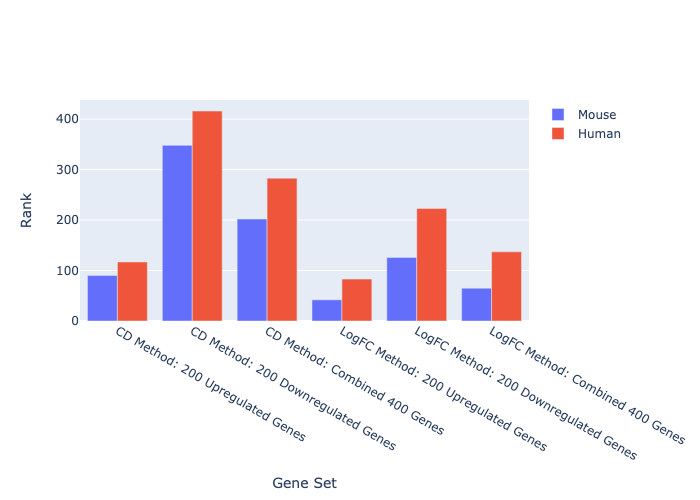

In [19]:
# Compare rankings/methods
# Bar chart based on the rankings
fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Gene Set'],
    y=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse"))
fig1.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Gene Set'],
    y=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human"))
fig1.update_layout(barmode='group')
fig1.update_layout(xaxis={'title':{'text':'Gene Set'}}, 
                yaxis={'title':{'text':'Rank'}})
fig1.show("png")

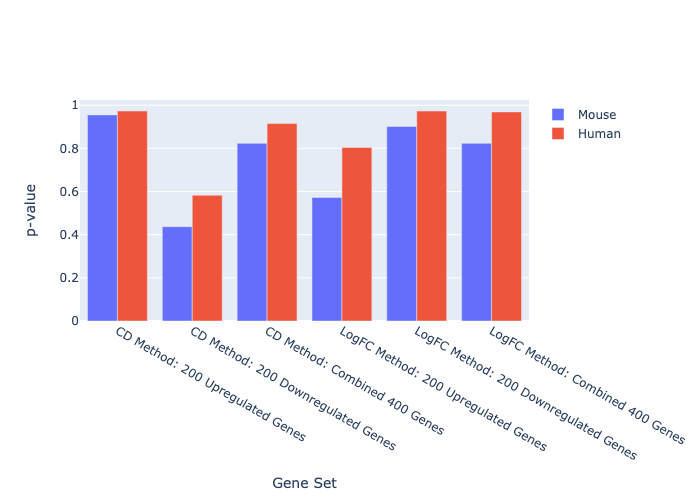

In [20]:
# Bar chart based on p-values
fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Gene Set'],
    y=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['p-value'],
    name="Mouse"))
fig2.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Gene Set'],
    y=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['p-value'],
    name="Human"))
fig2.update_layout(xaxis={'title':{'text':'Gene Set'}}, 
                yaxis={'title':{'text':'p-value'}})
fig2.show("png")

In [21]:
# Calculate and sort by mean rank grouping by method and name
df.groupby(['Method', 'Name']).mean().sort_values(by='Rank')

Rank   p-value
Method Name                                                      
LogFC  NR3C1 23031785 ChIP-Seq PC12 Mouse     77.666667  0.765627
       NR3C1 21868756 ChIP-Seq MCF10A Human  147.666667  0.915334
CD     NR3C1 23031785 ChIP-Seq PC12 Mouse    213.333333  0.738484
       NR3C1 21868756 ChIP-Seq MCF10A Human  272.000000  0.823627

In [22]:
# Getting ranks of each method as a list
cd_ranks = df[df["Method"] == 'CD']['Rank'].tolist()
fc_ranks = df[df["Method"] == 'LogFC']['Rank'].tolist()

# Report results of Wilcoxon test
w, p = ss.wilcoxon(cd_ranks, fc_ranks)

print("The p-value for CD and LogFC is " + str(p))

significance_threshold = 0.05
if p < significance_threshold:
    print("CD and LogFC are statistically significantly different")
else:
    print("CD and LogFC are not statistically significantly different")

The p-value for CD and LogFC is 0.03125
CD and LogFC are statistically significantly different
